
Total Classes Detected: 43
Importing Classes.....
Class 0 -> 0 (180 images)
Class 1 -> 1 (1980 images)
Class 2 -> 10 (1800 images)
Class 3 -> 11 (1170 images)
Class 4 -> 12 (1890 images)
Class 5 -> 13 (1920 images)
Class 6 -> 14 (690 images)
Class 7 -> 15 (540 images)
Class 8 -> 16 (360 images)
Class 9 -> 17 (990 images)
Class 10 -> 18 (1080 images)
Class 11 -> 19 (180 images)
Class 12 -> 2 (2010 images)
Class 13 -> 20 (300 images)
Class 14 -> 21 (270 images)
Class 15 -> 22 (330 images)
Class 16 -> 23 (450 images)
Class 17 -> 24 (240 images)
Class 18 -> 25 (1350 images)
Class 19 -> 26 (540 images)
Class 20 -> 27 (210 images)
Class 21 -> 28 (480 images)
Class 22 -> 29 (240 images)
Class 23 -> 3 (1260 images)
Class 24 -> 30 (390 images)
Class 25 -> 31 (690 images)
Class 26 -> 32 (210 images)
Class 27 -> 33 (599 images)
Class 28 -> 34 (360 images)
Class 29 -> 35 (1080 images)
Class 30 -> 36 (330 images)
Class 31 -> 37 (180 images)
Class 32 -> 38 (1860 images)
Class 33 -> 39 (270 images)


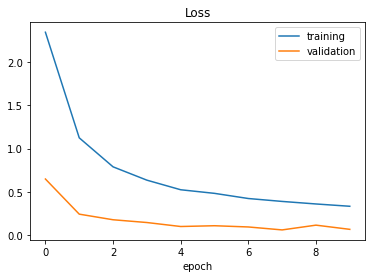

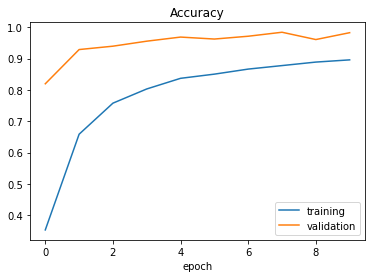

Test Score: 0.07010074704885483
Test Accuracy: 0.9816091656684875


C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# ✅ Use tensorflow.keras instead of keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =====================
# CONFIG
# =====================
path = r"C:\Users\Dell\Downloads\Projects\traffic_sign_recognition-main\traffic_sign_recognition-main\Dataset\Dataset"
labelFile = 'labels.csv'
batch_size_val = 32
epochs_val = 10
imageDimensions = (32, 32, 3)
testRatio = 0.2
validationRatio = 0.2

# =====================
# LOAD DATASET
# =====================
images = []
classNo = []

# ✅ Get all subfolders inside Dataset
myList = sorted(os.listdir(path))
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)

print("Importing Classes.....")
for class_id, folder in enumerate(myList):
    class_path = os.path.join(path, folder)
    if os.path.isdir(class_path):  # only loop through folders
        myPicList = os.listdir(class_path)
        for y in myPicList:
            curImg = cv2.imread(os.path.join(class_path, y))
            if curImg is not None:
                curImg = cv2.resize(curImg, (imageDimensions[0], imageDimensions[1]))  # resize
                images.append(curImg)
                classNo.append(class_id)
        print(f"Class {class_id} -> {folder} ({len(myPicList)} images)")

images = np.array(images)
classNo = np.array(classNo)

# =====================
# SPLIT DATA
# =====================
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio, random_state=42)

print("Data Shapes:")
print("Train", X_train.shape, y_train.shape)
print("Validation", X_validation.shape, y_validation.shape)
print("Test", X_test.shape, y_test.shape)

# =====================
# PREPROCESSING
# =====================
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def equalize(img):
    return cv2.equalizeHist(img)

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

# Reshape for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# =====================
# DATA AUGMENTATION
# =====================
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

# =====================
# ONE HOT ENCODING
# =====================
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

# =====================
# MODEL
# =====================
def myModel():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(imageDimensions[0], imageDimensions[1], 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())

# =====================
# TRAINING
# =====================
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=len(X_train) // batch_size_val,
                    epochs=epochs_val,
                    validation_data=(X_validation, y_validation),
                    shuffle=True)

# =====================
# PLOT RESULTS
# =====================
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

# =====================
# EVALUATE
# =====================
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# =====================
# SAVE MODEL
# =====================
model.save("model.h5")
